# Visualizing Attention Between Two Graphs

## Loading a model

$\bullet$ Load a model's state and configurations (a model from "./checkpoints/");
$\bullet$ Using configurations to initialize the correct model;
$\bullet$ Update weights based on trained weights.

In [1]:
from model import GraphMatchingNetwork, GraphConvolutionNetwork
import torch

# Load checkpoint (full)
filename = f'./checkpoints/gmn_glad-bird-6.pth.tar'
checkpoint = torch.load(filename, map_location=lambda storage,
                        loc: storage.cuda() if torch.cuda.is_available() else storage.cpu())

# Retrieve state dict and configurations
state_dict = checkpoint['state_dict']
cfg = checkpoint['config']

# Initialize model
model = GraphMatchingNetwork(cfg)

# Load weights (state dict) into the model
model.load_state_dict(state_dict)  # should output "<All keys matched successfully>"

<All keys matched successfully>

## Two dummy graphs

Let's create two small graphs $G_1$ and $G_2$. </br>
They have the same number of nodes ($N=5$). </br>
$G_2$ has one more edge, hence $\text{GED}(G_1, G_2)=1$

In [2]:
import networkx as nx

# Graph 1
G1 = nx.Graph()
G1.add_nodes_from([1, 2, 3, 4, 5])
G1.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 1), (4, 5)])

# Graph 2: Graph 1 + one extra edge -> GED(G1, G2) = 1
G2 = nx.Graph()
G2.add_nodes_from([1, 2, 3, 4, 5])
G2.add_edges_from([(1, 2), (2, 3), (2, 4), (3, 4), (4, 1), (4, 5)])

Let's plot the differences:

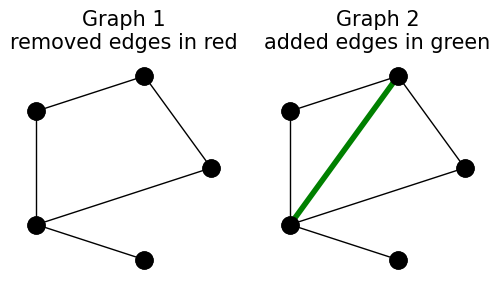

In [3]:
from plot import plot_difference_graphs

# figure settings
fs = 3
node_size = fs*50
edge_size = fs/3

# plot difference
plot_difference_graphs(G1, G2, fs=fs, fs_title=5, node_size=node_size, edge_size=edge_size)

## Compute cross-graph attention (node-to-node)

$\bullet$ Get node features (for a number of layers);
$\bullet$ Compute attention scores $a_k^{(m \rightarrow n)}$ as a softmax-normalized dot-product between $\mathbf{h}_k^{(n)}$ and $\mathbf{h}_k^{(m)}$, computed as:

$$
a_k^{(j \rightarrow n)} =
\frac{
\exp \left( \mathbf{h}_k^{(n)} \cdot \mathbf{g}_k^{(j)} \right)
}
{
\sum_{j'\in\mathcal{E}_2}{
\exp \left( \mathbf{h}_k^{(n)} \cdot \mathbf{g}_k^{(j')} \right)
}
};
$$

$\bullet$ Note that: $n \in \mathcal{N}_1$ and $m \in \mathcal{N}_2$, or vice versa;
$\bullet$ Average $a_k^{(m \rightarrow n)}$ and $a_k^{(n \rightarrow m)}$ to get $a_k^{(n, m)}$:

$$
a_k^{(n, m)} = a_k^{(m, n)} = \frac{a_k^{(m \rightarrow n)} + a_k^{(n \rightarrow m)}}{2};
$$
$\bullet$ $a_k^{(n, m)}$ is taken as the final attention weight;
$\bullet$ The attention weight reflects the similarity between two nodes $\longrightarrow$ in the plot the line thickness and color between two nodes depends on the attention weight.